*Unit 4, Sprint 1, Module 4*

---

# Topic Modeling (Prepare)


![](https://drive.google.com/uc?export=view&id=1Aze8Xe_ZZpV22IwFNUH09T2howHmF1AK)

[Image Credit: slides from Ben Mabey](https://speakerdeck.com/bmabey/visualizing-topic-models)

In Module 1, we talked about summarizing your documents using just token counts. Today, we're going to learn about a much more sophisticated approach - learning 'topics' from documents. Topics are a latent structure. They are often not explicitly called out and labeled in the document corpus. So some extra work is needed to figure out the topics. Today we will learn a powerful technique for doing this (almost) automatically!

> **latent**: existing but not yet developed or manifest; hidden or concealed.

## Use Cases
Primary use case: What the are your documents about? <br>
What are some industrial applications?
* Identifying common themes in customer reviews
* Grouping job ads into categories
* Sorting customer inquiries into categories so they can be routed to the appropriate department for processing.
* Monitoring communications (Email - State Department, Google)

## Learning Objectives
*At the end of the lesson you should be able to:*
* Part 1: Describe how a Latent Dirichlet Allocation (LDA) Model works
* Part 2: Build a LDA Model with Gensim
* Part 3: Interpret LDA results & Select an appropriate number of topics

##1.0 Setup

##1.0.1 Get spacy

In [1]:
# could use *web_lg or *web_sm instead
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 15.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## 1.0.1 Restart runtime!
On Colab, we need to restart runtime after this step, <br>
or else Colab won't find spacy!

##1.0.2 Install dependencies

In [1]:
# Dependencies for the week (instead of conda)
# Run if you're using colab, otherwise you should have a local copy of the data
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/main/requirements.txt
!pip install -r requirements.txt

--2024-07-03 19:10:30--  https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/main/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]     132  --.-KB/s    in 0s      

2024-07-03 19:10:30 (4.34 MB/s) - ‘requirements.txt’ saved [132/132]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 19.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

##1.0.3 Imports and such

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from sklearn.datasets import fetch_20newsgroups
from pandarallel import pandarallel

import spacy
spacy.util.fix_random_seed(0)

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Part 1: Building a Latent Dirichlet Allocation (LDA) Topic Model with Gensim

Our goal in this module is to get hands-on experience in how to build and train a Latent Dirichlet Allocation topic model using the **Gensim** library.

## 1.1 Latent Dirichlet Allocation (LDA)
is a more sophisticated method of topic modelling than Latent Semantic Indexing (LSI) which we used in Module 2. Because of its complexity, a full discussion of the machinery of LDA is beyond the scope of Unit 4. We'll focus on a high level of understanding of Latent Dirichlet Allocation, meaning we'll emphasize "what it does" rather than "how it does it".

LDA takes as input the corpora of documents and the number of topics that you want to identify. LDA models topics as probability distributions over words, and it models documents as probability distributions over topics.

LDA is a generative probabilistic model. That means it can generate documents from probability distributions. Given an article length (number of words), an assumed probability distribution of topics, and an assumed distribution of words for each topic, LDA can generate an article, in the form of a bag of words. LDA works by starting with random distributions of words over topics and  topics over documents, then iteratively adjust these probability distributions until the generated documents are similar in structure to the input documents.





### 1.1.1 Resources for LDA

[**Your Guide to Latent Dirichlet Allocation**](https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d) is a highly recommended Medium article that works through an example of LDA in elementary terms

[**LDA Topic Modeling**](https://lettier.com/projects/lda-topic-modeling/) is an interactive data visualization tool -- created by the author of the above article -- that allows us to explore a simple and visual example of LDA.

[**Topic Modeling with Gensim**](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/) disccusses an example implementing LDA using the same dataset that we are using in this guided project.  

Luis Serrano's video [**Latent Dirichlet Allocation**](https://youtu.be/T05t-SqKArY) does a great job of breaking down and explaining LDA in an understandable way.



### 1.1.2 Further discussion of LDA (Optional)

LDA is a [**Probabilistic Graphical Model (PGM)**](https://en.wikipedia.org/wiki/Graphical_model)

A PGM can be represented by a graph that expresses the conditional dependence structure between random variables. Here's a graphical representation of the LDA model:

![](https://filebox.ece.vt.edu/~s14ece6504/projects/alfadda_topic/main_figure_3.png)

The image shows the hierarchical dependency between probability distributions and their parameters. This is an application of Hierarchical Bayesian Modeling.

In order to understand how LDA works, one must first understand how PGMs work, which is beyond the scope of Unit 4. If this is something that you're interested in learning more about, here are some resources:

This Github repo that has transformed a textbook in a collection of Jupyter Notebooks. This repo is called [**"Bayesian Methods for Hackers"**](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) <br>
The cool thing about this repo is that each chapter covers the same material using four popular python probabilistic modeling libraries: **PyMC2, PyMC3, Pyro, and Tensorflow Probability.** So you can choose your preferred library.

[**Pyro**](https://pyro.ai/) is considered a very powerful probabilistic programming library that even combines probabilistic programming with deep learning.

## 1.2 Preparing our text data set for LDA topic modeling with `gensim`
For this guided project we'll work with the `20newsgroups` data set that is  familiar from Module 3, but we'll extract articles from a different set of categories.<br><br>
`gensim` is a Natural Language Processing Library, specialized for Topic Modeling applications. The two main inputs required for a `gensim` LDA topic model are the dictionary (`id2word`) and the `corpus`.<br><br>
`id2word` is a special object created by `gensim` that keeps track of the mapping from text to numerical index, and the mapping from numerical index back to text <br><br>
The `corpus` is a specially formatted list containing information about each document. Though its format is different, is essentially equivalent to the document-term matrix that we used with `sklearn`.<br>

In this section, we will first download and clean the raw text documents, then use `spacy` to tokenize and lemmatize them. Then we'll use `gensim` to create the `id2word` and `corpus` objects that we need for topic modeling with `gensim`<br>

In Part 2, we'll build and train the LDA topic model in `gensim`.

References:
- [Gensim Tutorial – A Complete Beginners Guide](https://www.machinelearningplus.com/nlp/gensim-tutorial/)
- [Topic Modeling with Gensim (Python)](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

# Problem Statement



We'll extract articles belonging to the following four topics (as assigned in the 20newsgroups database)

    sci
        \_ electronics, space


    talk
        \_politics
                  \_ guns, middle east
              
What's the best way to categorize these emails - is it between science and talk?

Or it between electronics, space, guns, and the Middle East?

The Middle East is a pretty broad topic in and of itself, should that topic be broken down into further sub-topics?

Let's learn about Topic Modeling and how it can help us answer these questions!

### Load Email Corpus


In [3]:
# notice that the categories are hierarchical
# so there is a sense in which we have 2 topics, but also as many as 4 topics
categories = ['sci.electronics', 'sci.space',
              'rec.sport.baseball', 'rec.sport.hockey']
data = fetch_20newsgroups(subset='all',
                          remove=('headers', 'footers', 'quotes'),
                          random_state=42, shuffle=True,
                          categories=categories)

In [4]:
dir(data)

['DESCR', 'data', 'filenames', 'target', 'target_names']

In [5]:
# create X and y from data, as we did in the Module 3 Lecture notebook
###BEGIN SOLUTION
X = data.data
y = data.target
target_names = data.target_names
###END SOLUTION

What are the possible targets (labels)

In [6]:
np.unique(y)

array([0, 1, 2, 3])

What are the newsgroup names that correspond to the labels?

In [7]:
target_names

['rec.sport.baseball', 'rec.sport.hockey', 'sci.electronics', 'sci.space']

Create a data frame with columns for the documents, the newsgroup names, and their numerical labels.

In [8]:
data_dict = {
    'content': X,
    'target': y,
    'target_names': [target_names[target_index] for target_index in y]
}

df = pd.DataFrame(data=data_dict)
print(df.shape)
df.head()

(3964, 3)


,content,target,target_names
0,\nWhat you have is one of the LD players from ...,2,sci.electronics
1,"\n\n\n\n\n\nWell, I thought it must have been ...",3,sci.space
2,Sounds like a job for a universal time recieve...,2,sci.electronics
3,"""Space Station Redesign Leader Says Cost Goal ...",3,sci.space
4,\nThey aren't going to leave a loophole as gla...,3,sci.space


Re-use our `clean_data()` helper function from Module 3.

In [9]:
def clean_data(text):
    """
    Accepts a single text document and performs several regex substitutions in order to clean the document.

    Parameters
    ----------
    text: string or object

    Returns
    -------
    text: string or object
    """

    # order of operations - apply the expression from top to bottom
    email_regex = "From: \S*@\S*\s?"
    non_alpha = '[^a-zA-Z]'
    multi_white_spaces = "[ ]{2,}"

    text = re.sub(email_regex, "", text)
    text = re.sub(non_alpha, ' ', text)
    text = re.sub(multi_white_spaces, " ", text)

    # apply case normalization
    return text.lower().lstrip().rstrip()

Clean the text string data and save it in a new column

In [10]:
df["clean_data"] = df["content"].apply(clean_data)
df.head()

,content,target,target_names,clean_data
0,\nWhat you have is one of the LD players from ...,2,sci.electronics,what you have is one of the ld players from a ...
1,"\n\n\n\n\n\nWell, I thought it must have been ...",3,sci.space,well i thought it must have been a joke but i ...
2,Sounds like a job for a universal time recieve...,2,sci.electronics,sounds like a job for a universal time recieve...
3,"""Space Station Redesign Leader Says Cost Goal ...",3,sci.space,space station redesign leader says cost goal m...
4,\nThey aren't going to leave a loophole as gla...,3,sci.space,they aren t going to leave a loophole as glari...


### Create Tokens

Before we can use the `gensim` library to create bag-of-words vectors in exactly the right way that the LDA model wants, we must first create tokens.

Let's use spaCy to create some lemmas. But first let's initialize our multi-processing library `pandarallel` which will empower us to use the same dataframe that our data is stored in but be able to create tokens in parallel so as to save time.

Here's the documentation for [**pandarallel**](https://github.com/nalepae/pandarallel)

In [11]:
# we must initalize pandarallel before we can use it
pandarallel.initialize(progress_bar=True, nb_workers=10)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [12]:
# load in our spaCy language model
nlp = spacy.load("en_core_web_md", disable=['tagger', 'parser'])

In [13]:
%%time
# create our tokens in the form of lemmas

# If you're on macOS, Linux, or python session executed from Windows Subsystem for Linux (WSL)
# conda activate U4-S1-NLP
# pip install pandarallel
#
# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True)
#
# Ref: https://github.com/nalepae/pandarallel
#
# from tqdm import tqdm
# tqdm.pandas()
#
# df['lemmas'] = df['content'].parallel_apply(get_lemmas)

# Parallel_map takes about 20 sec
df['lemmas'] = df['clean_data'].parallel_map(lambda x: [token.lemma_.strip() for token in nlp(x) if (token.is_stop != True) and (token.is_punct != True)])

CPU times: user 1.18 s, sys: 351 ms, total: 1.53 s
Wall time: 1min 36s


### Take a look at our lemmas

In [15]:
df['clean_data'][12]

'i recently bought an apparantly complete expansion chassis by mountain computer inc it consists of a box with apple compatible slots powersupply brick interface card and ribbon cable to attach it to the computer to be expanded there was also included a small card with empty sockets on top and pins on the bottom that looks like it would plug into the motherboard somewhere after pulling a chip there s an empty socket also on the interface card and a short pin dip jumper like the ones used with language cards this technological marvel came with no docs and i haven t a clue as how to hook this thing up if anyone has docs and or users disk of any sort for this i could really use copies of them or at least some help i need to know o how to orient the ribbon cable between the card and the chassis o how to attach the short cable from the motherboard to the card and if the small card is used o the purposes of the various jumper pins on the card it has more of those than my cms scsi card'

In [16]:
# print out the lemmas from the first article
# note that some lemmas are only 1 character: you could modify the code above to not include lemmas that are only 1 or 2 characters
df['lemmas'][12]

['recently',
 'bought',
 'apparantly',
 'complete',
 'expansion',
 'chassis',
 'mountain',
 'computer',
 'inc',
 'consists',
 'box',
 'apple',
 'compatible',
 'slots',
 'powersupply',
 'brick',
 'interface',
 'card',
 'ribbon',
 'cable',
 'attach',
 'computer',
 'expanded',
 'included',
 'small',
 'card',
 'sockets',
 'pins',
 'looks',
 'like',
 'plug',
 'motherboard',
 'pulling',
 'chip',
 's',
 'socket',
 'interface',
 'card',
 'short',
 'pin',
 'dip',
 'jumper',
 'like',
 'ones',
 'language',
 'cards',
 'technological',
 'marvel',
 'came',
 'docs',
 'haven',
 't',
 'clue',
 'hook',
 'thing',
 'docs',
 'users',
 'disk',
 'sort',
 'use',
 'copies',
 'help',
 'need',
 'know',
 'o',
 'orient',
 'ribbon',
 'cable',
 'card',
 'chassis',
 'o',
 'attach',
 'short',
 'cable',
 'motherboard',
 'card',
 'small',
 'card',
 'o',
 'purposes',
 'jumper',
 'pins',
 'card',
 'cms',
 'scsi',
 'card']

### Filter out low quality lemmas
1 or 2 characters

In [17]:
def filter_lemmas(lemmas):
    """
    Filter out any lemmas that are 2 characters or smaller
    """
    return [lemma for lemma in lemmas if len(lemma) > 2]

In [18]:
# apply filter_lemmas
# YOUR CODE HERE
df["filtered_lemmas"] = df["lemmas"].parallel_map(filter_lemmas)

In [19]:
df["filtered_lemmas"][12]

['recently',
 'bought',
 'apparantly',
 'complete',
 'expansion',
 'chassis',
 'mountain',
 'computer',
 'inc',
 'consists',
 'box',
 'apple',
 'compatible',
 'slots',
 'powersupply',
 'brick',
 'interface',
 'card',
 'ribbon',
 'cable',
 'attach',
 'computer',
 'expanded',
 'included',
 'small',
 'card',
 'sockets',
 'pins',
 'looks',
 'like',
 'plug',
 'motherboard',
 'pulling',
 'chip',
 'socket',
 'interface',
 'card',
 'short',
 'pin',
 'dip',
 'jumper',
 'like',
 'ones',
 'language',
 'cards',
 'technological',
 'marvel',
 'came',
 'docs',
 'haven',
 'clue',
 'hook',
 'thing',
 'docs',
 'users',
 'disk',
 'sort',
 'use',
 'copies',
 'help',
 'need',
 'know',
 'orient',
 'ribbon',
 'cable',
 'card',
 'chassis',
 'attach',
 'short',
 'cable',
 'motherboard',
 'card',
 'small',
 'card',
 'purposes',
 'jumper',
 'pins',
 'card',
 'cms',
 'scsi',
 'card']

### The two main inputs to the `gensim` LDA topic model are the dictionary (`id2word`) and the `corpus`.
- `id2word` is a special object created by `gensim` that keeps track of the mapping from text to numerical index, and the mapping from numerical index back to text <br>
- The `corpus` is a specially formatted list containing information about each document. Though its format is different, is essentially equivalent to the document-term matrix that we used with `sklearn`

### Create the `id2word` dictionary

In [20]:
# 1. Create Dictionary

# 2. Term Document Frequency is (token id, token count) for each doc in the corpus

# 3. Human readable format of corpus (term-frequency)

### BEGIN SOLUTION
# 1. Create Dictionary from the corpus
id2word = corpora.Dictionary(df['filtered_lemmas'])

In [21]:
# How many words do we have in our vocabulary?
len(id2word.keys())

27132

In [22]:
# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=3, no_above=0.5)

In [23]:
# Now how many words do we have in our vocabulary dictionary?
len(id2word.keys())

10576

Use the `id2word.doc2bow()` method to process a first document into a list of word counts

In [24]:
df['clean_data'].iloc[5]

'boxscores beware the original poster looks to be from louisville and chances are louisville gets the edition of the nytimes that is printed in chicago for the midwest this edition has boxscores only on monday and sunday and an extremely skimpy sports section few game summaries mostly just color stories'

In [25]:
id2word.doc2bow(df['filtered_lemmas'][5])

[(9, 1),
 (117, 1),
 (207, 1),
 (208, 2),
 (209, 1),
 (210, 1),
 (211, 1),
 (212, 2),
 (213, 1),
 (214, 1),
 (215, 1),
 (216, 2),
 (217, 1),
 (218, 1),
 (219, 1),
 (220, 1),
 (221, 1),
 (222, 1),
 (223, 1),
 (224, 1),
 (225, 1),
 (226, 1)]

### Create the `corpus`
by processing all the documents using a list comprehension

In [26]:
# 2. Term Document Frequency

# We want a list of (token id, token count) for each doc in the corpus

# Term Document Frequency -- different format, but equivalent in function to the document-term matrix we used in sklearn
corpus = [id2word.doc2bow(doc_lemmas) for doc_lemmas in df['filtered_lemmas']]

# Check the data type and length of corpus
print(type(corpus))
print(len(corpus))

<class 'list'>
3964


In [27]:

### BEGIN SOLUTION

# 3. Human readable format of corpus (term-frequency)
[(id2word[word_id], word_count) for word_id, word_count in corpus[5]]

### END SOLUTION

[('game', 1),
 ('monday', 1),
 ('beware', 1),
 ('boxscores', 2),
 ('chances', 1),
 ('chicago', 1),
 ('color', 1),
 ('edition', 2),
 ('extremely', 1),
 ('gets', 1),
 ('looks', 1),
 ('louisville', 2),
 ('midwest', 1),
 ('original', 1),
 ('poster', 1),
 ('printed', 1),
 ('section', 1),
 ('skimpy', 1),
 ('sports', 1),
 ('stories', 1),
 ('summaries', 1),
 ('sunday', 1)]

# Part 2: Estimate a Latent Dirichlet Allocation (LDA) Model with `gensim`

 ### Train an LDA model

In [28]:
### This cell runs the single-processor version of the model (slower)
# %%time
# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=20,
#                                            chunksize=100,
#                                            passes=10,
#                                            per_word_topics=True)
# lda_model.save('lda_model.model')
# # https://radimrehurek.com/gensim/models/ldamodel.html

#### The multi-processor version of gensim's LDA model is `gensim.models.ldamulticore.LdaMulticore()`, <br> which runs faster than the single-core version `gensim.models.ldamodel.LdaModel()`


In [29]:
%%time
from gensim.models.ldamulticore import LdaMulticore


num_topics = 2
lda_multicore_2_topics = LdaMulticore(corpus=corpus,
                                      id2word=id2word,
                                      num_topics=num_topics,
                                      chunksize=250,
                                      passes=20,              # Runtime related parameter
                                      per_word_topics=True,
                                      workers=10,             # Set based on your machine capability
                                      random_state=42)

CPU times: user 11.7 s, sys: 612 ms, total: 12.3 s
Wall time: 49.5 s


In [30]:
num_topics = 6
lda_multicore_6_topics = LdaMulticore(corpus=corpus,
                                      id2word=id2word,
                                      num_topics=num_topics,
                                      chunksize=250,
                                      passes=20,
                                      per_word_topics=True,
                                      workers=10,
                                      random_state=42)

# Part 3: Interpret LDA results & Select the appropriate number of topics
LDAvis provides an interactive visualization of the topics estimated using Latent Dirichlet Allocation (LDA).<br>
We will use the `pyLDAvis` library which implements [LDAvis](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf) in `python`.<br>


### 3.1 Visualizing the topics in our models

In [31]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_multicore_2_topics, corpus, id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.151068  0.0       1        1  54.281623
1     -0.151068  0.0       2        1  45.718377, topic_info=       Term         Freq        Total Category  logprob  loglift
9      game  1205.000000  1205.000000  Default  30.0000  30.0000
23    space  1244.000000  1244.000000  Default  29.0000  29.0000
155    team   984.000000   984.000000  Default  28.0000  28.0000
569   games   668.000000   668.000000  Default  27.0000  27.0000
526  season   528.000000   528.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
36     like   509.132224  1192.285614   Topic2  -5.4327  -0.0682
907    best   282.212714   384.985174   Topic2  -6.0228   0.4721
996  second   282.976829   406.309649   Topic2  -6.0201   0.4209
613     new   330.868782   686.582443   Topic2  -5.8637   0.0527
34     know   344.661465   820.648800   Topic2  -5.8229  -0.0849

[156 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3766      1  0.987964  atmosphere
3766      2  0.012666  atmosphere
1108      1  0.872540   available
1108      2  0.125808   available
494       1  0.012037    baseball
...     ...       ...         ...
27        2  0.206927        work
989       1  0.183840        year
989       2  0.815729        year
868       1  0.534464       years
868       2  0.466311       years

[238 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [32]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_multicore_6_topics, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.175411  0.001470       1        1  23.016476
3      0.177272  0.021077       2        1  22.661644
2      0.066682 -0.154974       3        1  17.703429
4     -0.006616 -0.098254       4        1  16.417975
0      0.177478  0.147359       5        1  10.373952
5     -0.239405  0.083322       6        1   9.826524, topic_info=        Term         Freq        Total Category  logprob  loglift
23     space  1284.000000  1284.000000  Default  30.0000  30.0000
9       game  1192.000000  1192.000000  Default  29.0000  29.0000
155     team   973.000000   973.000000  Default  28.0000  28.0000
4098     pts   301.000000   301.000000  Default  27.0000  27.0000
1331  period   443.000000   443.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
613      new   125.658460   683.552500   Topic6  -5.2945   0.6263
996   second   106.455025   403.038308   Topic6  -5.4603   0.9888
88      goal   100.744348   297.574794   Topic6  -5.5154   1.2370
205      won   102.949604   392.888018   Topic6  -5.4938   0.9808
989     year    95.635996  1004.574129   Topic6  -5.5675  -0.0317

[490 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1159      1  0.050946    ability
1159      2  0.101892    ability
1159      3  0.089156    ability
1159      4  0.700510    ability
1159      6  0.050946    ability
...     ...       ...        ...
868       3  0.083532      years
868       4  0.216092      years
868       5  0.212461      years
868       6  0.067188      years
5326      6  0.944269  zelepukin

[1165 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 5, 1, 6])

###3.2 What is topic coherence?


_Topic Coherence measures score a single topic by
measuring the degree of semantic similarity between
high scoring words in the topic._ <br>
-- From "Exploring Topic Coherence over many models and many topics", by Keith Stevens, Philip Kegelmeyer, David Andrzejewski, and David Buttler, Proceedings of the 2012 Joint Conference on Empirical Methods in Natural Language Processing and Computational Natural
Language Learning, pages 952–961, Jeju Island, Korea, 12–14 July 2012.
c 2012 Association for Computational Linguistics

_A set of statements or facts is said to be coherent, if they
support each other. Thus, a coherent fact set can be interpreted
in a context that covers all or most of the facts. An
example of a coherent fact set is 'the game is a team sport',
'the game is played with a ball', and 'the game demands great
physical e
fforts'_ -- from "Exploring the Space of Topic Coherence Measures", by Michael Roder, Andreas Both and Alexander Hinneburg https://dl.acm.org/doi/10.1145/2684822.2685324

We expect that documents in a topic category should be coherent, i.e., they should relate to each other. The same is true for words within a topic.


### Let's tune the "number of topics" hyperparameter
and choose the model with the best Topic Coherence score.

In [33]:
def compute_coherence_values(dictionary, corpus, texts, limit=None, start=None, step=None):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics,
                                                        chunksize=100,
                                                        passes=10,
                                                        random_state=1234,
                                                        per_word_topics=True,
                                                        workers=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [34]:
%%time
# takes about 3 min
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df['filtered_lemmas'], start=2, limit=10, step=1)

CPU times: user 53.5 s, sys: 3.43 s, total: 57 s
Wall time: 3min 36s


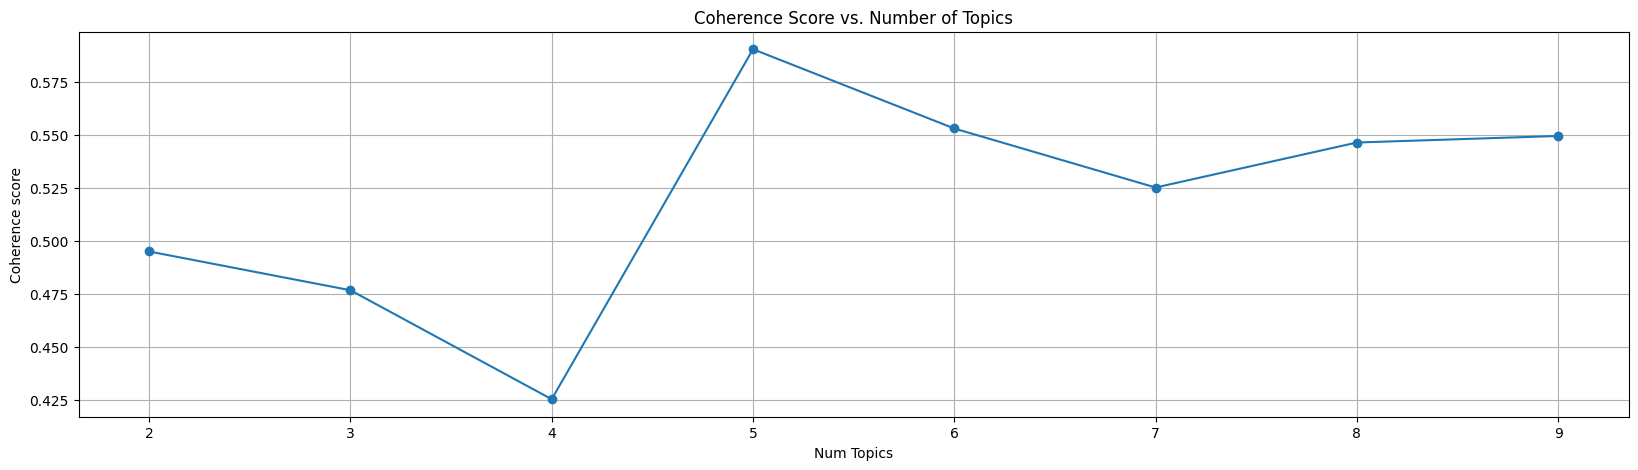

In [35]:
start=2; limit=10;  step=1;
x = range(start, limit, step)

plt.figure(figsize=(20,5))
plt.grid()
plt.plot(x, coherence_values, "-o")
plt.title("Coherence Score vs. Number of Topics")
plt.xticks(x)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show();

### Select the "best" model as the one with the highest Topic Coherence Score

Due to the probabilistic nature of this model, the modeling results can and usually do vary. Despite this, we will select 8 as the number of topics even if this particular model run doesn't show 8 as having the highest coherence score. Also, even if it doesn't, we  need to ask ourselves how many topics we actually want for our corpus.

In [36]:
lda_trained_model = model_list[3]

In [37]:
lda_trained_model

### For each topic discovered by `gensim`, list the top ten words and their probabilities,

In [38]:
pprint(lda_trained_model.print_topics())

[(0,
  '0.017*"space" + 0.007*"nasa" + 0.005*"earth" + 0.004*"system" + '
  '0.004*"data" + 0.004*"orbit" + 0.004*"shuttle" + 0.004*"moon" + '
  '0.004*"mission" + 0.003*"solar"'),
 (1,
  '0.010*"hockey" + 0.007*"new" + 0.007*"pts" + 0.007*"team" + 0.006*"pit" + '
  '0.005*"nhl" + 0.005*"game" + 0.005*"games" + 0.004*"april" + '
  '0.004*"launch"'),
 (2,
  '0.009*"period" + 0.008*"game" + 0.006*"goal" + 0.006*"play" + 0.005*"don" + '
  '0.005*"shots" + 0.005*"like" + 0.004*"got" + 0.004*"power" + 0.004*"time"'),
 (3,
  '0.008*"use" + 0.006*"like" + 0.005*"don" + 0.005*"know" + 0.005*"need" + '
  '0.004*"good" + 0.004*"want" + 0.004*"ground" + 0.004*"power" + '
  '0.004*"work"'),
 (4,
  '0.011*"game" + 0.010*"year" + 0.009*"team" + 0.009*"don" + 0.008*"think" + '
  '0.007*"good" + 0.007*"like" + 0.006*"games" + 0.006*"time" + '
  '0.005*"players"')]


###Visualize the topics in the best model

In [39]:
# visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_trained_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.125242  0.068117       1        1  27.502502
0      0.163897 -0.066712       2        1  27.002975
3      0.132682  0.090240       3        1  19.994372
1     -0.083862 -0.145267       4        1  14.043287
2     -0.087476  0.053622       5        1  11.456864, topic_info=        Term         Freq        Total Category  logprob  loglift
23     space  1311.000000  1311.000000  Default  30.0000  30.0000
9       game  1205.000000  1205.000000  Default  29.0000  29.0000
508   hockey   520.000000   520.000000  Default  28.0000  28.0000
155     team   996.000000   996.000000  Default  27.0000  27.0000
1331  period   380.000000   380.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
1142    went    62.543460   168.126843   Topic5  -6.1457   1.1777
285     didn    64.806091   329.271525   Topic5  -6.1101   0.5411
1650    blue    59.691928   149.749785   Topic5  -6.1923   1.2468
967   series    62.041670   315.093343   Topic5  -6.1537   0.5415
597     good    64.961373   870.831163   Topic5  -6.1077  -0.4291

[409 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
3515      3  0.014007    abc
3515      4  0.938476    abc
3515      5  0.042021    abc
3858      5  0.957434  adcom
3612      1  0.031279    ahl
...     ...       ...    ...
6189      5  0.922303  zombo
3313      1  0.248371   zone
3313      2  0.037256   zone
3313      4  0.074511   zone
3313      5  0.633345   zone

[1035 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 4, 2, 3])

## Create a Topic Id --> Topic Name dictionary


*****This is the "human intervention" step*****:<br>
Edit `vis_topic_name_dict` with YOUR OWN names that YOU assign to the topics that `gensim` discovered.

When populating your Topic Id --> Topic Name dictionary, use the index ordering as shown in the `pyLDAvis` tool.

In [40]:
# keys - use topic ids from pyLDAvis visualization
# values - topic names that you create
# save dictionary to `vis_topic_name_dict`
###BEGIN SOLUTION
# this is the results from a model run however these topic names might not make sense in future model runs
# thus these names will likely have to be thought through during each lecture
vis_topic_name_dict = {1:"space program",
                       2:"electronics / power",
                       3:"hockey",
                       4:"baseball",
                       5:"hockey teams / players"}
###END SOLUTION

## Create a Topic Id lookup dictionary
We'll use a function to map the `pyLDAvis` index ordering to the ordering used in gensim's trained LDA model.

In [41]:
model_vis_tool_topic_id_lookup = vis.topic_coordinates.topics.to_dict()
model_vis_tool_topic_id_lookup

{4: 1, 0: 2, 3: 3, 1: 4, 2: 5}

In [42]:
topic_id_lookup =  {v:k for k, v in model_vis_tool_topic_id_lookup.items()}
topic_id_lookup

{1: 4, 2: 0, 3: 3, 4: 1, 5: 2}

In [43]:
def get_topic_id_lookup_dict(vis, vis_topic_name_dict):
    """
    Both the starting index and the ordering of topic ids bewteen the trained LDA model
    and the viz tool are different. So we need to create a look up dictionary that maps
    the correct association between topic ids from both sources.
    """
    # value is order of topic ids according to pyLDAvis tool
    # key is order of topic ids according to lda model
    model_vis_tool_topic_id_lookup = vis.topic_coordinates.topics.to_dict()

    # invert dictionary so that
    # key is order of topic ids accoridng to pyLDAvis tool
    # value is order of topic ids according to the trained lda model
    topic_id_lookup =  {v:k for k, v in model_vis_tool_topic_id_lookup.items()}

    # iterate through topic_id_lookup and index vis_topic_name_dict using the keys
    # in order to swap the viz topic ids in vis_topic_name_dict for the lda model topic ids
    return {v:vis_topic_name_dict[k]  for k, v in topic_id_lookup.items()}

In [44]:
###BEGIN SOLUTION
# now we have an updated topic id/name dict
# the topic ids correspond to how the lda model has indexed the topics
# now we can use this dictionary with lda model to label our docs
topic_name_dict = get_topic_id_lookup_dict(vis, vis_topic_name_dict)
###END SOLTUION

In [45]:
topic_name_dict

{4: 'space program',
 0: 'electronics / power',
 3: 'hockey',
 1: 'baseball',
 2: 'hockey teams / players'}

## Use the LDA Model to Assign Each Document a Topic Name

Now that we have a topic id/name look up dict that is aligned with the index ordering of the trained LDA model, we can move forward to giving each topic a topic name.

This function iterates over the documents in a corpus and outputs a list with the topic ID -- according to the trained `lda_model` -- of the highest-probability topic for each document

The function below has been given to you. However, you highly encouraged to read through it and make sure that you understand what it is doing each step of the way. In fact, a good way to do this is to copy and paste the code inside of the function into a new cell, comment out all the lines of code and line by line, uncomment the code and see the output.

In [46]:
def get_topic_ids_for_docs(lda_model, corpus):

    """
    Passes a Bag-of-Words vector into a trained LDA model in order to get the topic id of that document.

    Parameters
    ----------
    lda_model: Gensim object
        Must be a trained model

    corpus: nested lists of tuples,
        i.e. [[(),(), ..., ()], [(),(), ..., ()], ..., [(),(), ..., ()]]

    Returns
    -------
    topic_id_list: list
        Contains topic ids for all document vectors in corpus
    """

    # store topic ids for each document
    doc_topic_ids = []

    # iterature through the bow vectors for each doc
    for doc_bow in corpus:

        # store the topic ids for the doc
        topic_ids = []
        # store the topic probabilities for the doc
        topic_probs = []

        # list of tuples
        # each tuple has a topic id and the prob that the doc belongs to that topic
        topic_id_prob_tuples = lda_trained_model.get_document_topics(doc_bow)

        # iterate through the topic id/prob pairs
        for topic_id_prob in topic_id_prob_tuples:

            # index for topic id
            topic_id = topic_id_prob[0]
            # index for prob that doc belongs that the corresponding topic
            topic_prob = topic_id_prob[1]

            # store all topic ids for doc
            topic_ids.append(topic_id)
            # store all topic probs for doc
            topic_probs.append(topic_prob)

        # get index for largest prob score
        max_topic_prob_ind = np.argmax(topic_probs)
        # get corresponding topic id
        max_prob_topic_id = topic_ids[max_topic_prob_ind]
        # store topic id that had the highest prob for doc being a memebr of that topic
        doc_topic_ids.append(max_prob_topic_id)

    return doc_topic_ids

In [47]:
# get the topic id for each doc in the corpus
topic_id_list = get_topic_ids_for_docs(lda_trained_model, corpus)

# create a feature for document's topic id
df["topic_id"] = topic_id_list

# iterate through the topic id and use the lookup table to assign each document with a topic name
df["new_topic_name"] = df["topic_id"].apply(lambda topic_id: topic_name_dict[topic_id])
df.head()

,content,target,target_names,clean_data,lemmas,filtered_lemmas,topic_id,new_topic_name
0,\nWhat you have is one of the LD players from ...,2,sci.electronics,what you have is one of the ld players from a ...,"[ld, players, video, game, dragon, s, lair, sp...","[players, video, game, dragon, lair, space, ac...",3,hockey
1,"\n\n\n\n\n\nWell, I thought it must have been ...",3,sci.space,well i thought it must have been a joke but i ...,"[thought, joke, don, t, joke, read, aloud, dav...","[thought, joke, don, joke, read, aloud, david,...",2,hockey teams / players
2,Sounds like a job for a universal time recieve...,2,sci.electronics,sounds like a job for a universal time recieve...,"[sounds, like, job, universal, time, reciever,...","[sounds, like, job, universal, time, reciever,...",3,hockey
3,"""Space Station Redesign Leader Says Cost Goal ...",3,sci.space,space station redesign leader says cost goal m...,"[space, station, redesign, leader, says, cost,...","[space, station, redesign, leader, says, cost,...",0,electronics / power
4,\nThey aren't going to leave a loophole as gla...,3,sci.space,they aren t going to leave a loophole as glari...,"[aren, t, going, leave, loophole, glaring, spa...","[aren, going, leave, loophole, glaring, space,...",1,baseball


Using a boolean filter, or mask, you can slice out all articles of a certain topic, i.e. topic_id 3

In [48]:
mask = df.topic_id == 2
df[mask]

,content,target,target_names,clean_data,lemmas,filtered_lemmas,topic_id,new_topic_name
1,"\n\n\n\n\n\nWell, I thought it must have been ...",3,sci.space,well i thought it must have been a joke but i ...,"[thought, joke, don, t, joke, read, aloud, dav...","[thought, joke, don, joke, read, aloud, david,...",2,hockey teams / players
25,\n\n: I have one complaint for the cameramen d...,1,rec.sport.hockey,i have one complaint for the cameramen doing t...,"[complaint, cameramen, jersey, pitt, series, s...","[complaint, cameramen, jersey, pitt, series, s...",2,hockey teams / players
36,"On March 21, 1993 Roger Maynard wrote (in repl...",1,rec.sport.hockey,on march roger maynard wrote in reply to an ar...,"[march, roger, maynard, wrote, reply, article,...","[march, roger, maynard, wrote, reply, article,...",2,hockey teams / players
52,\n\n\n\n\n\n No one says you have to read any ...,0,rec.sport.baseball,no one says you have to read any of it ralph g...,"[says, read, ralph, play, traffic, nap, work]","[says, read, ralph, play, traffic, nap, work]",2,hockey teams / players
79,\n\n\n\nCareful. Making statements about how ...,3,sci.space,careful making statements about how solid stat...,"[careful, making, statements, solid, state, ge...","[careful, making, statements, solid, state, ge...",2,hockey teams / players
...,...,...,...,...,...,...,...,...
3909,\nAnd I lived out there too. It was a nice sl...,3,sci.space,and i lived out there too it was a nice sleepy...,"[lived, nice, sleepy, farm, valley, butler, fa...","[lived, nice, sleepy, farm, valley, butler, fa...",2,hockey teams / players
3915,"Piper lived in my town (Williamsport, PA) when...",3,sci.space,piper lived in my town williamsport pa when he...,"[piper, lived, town, williamsport, pa, killed,...","[piper, lived, town, williamsport, killed, ear...",2,hockey teams / players
3918,\nI too think that Joseph has had a GREAT year...,1,rec.sport.hockey,i too think that joseph has had a great year a...,"[think, joseph, great, year, considered, vezin...","[think, joseph, great, year, considered, vezin...",2,hockey teams / players
3926,\nI think you're both right. Teflon was actua...,3,sci.space,i think you re both right teflon was actually ...,"[think, right, teflon, actually, discovered, a...","[think, right, teflon, actually, discovered, a...",2,hockey teams / players


In [49]:
df[mask].target_names.value_counts(normalize=True)

target_names
rec.sport.hockey      0.397554
sci.space             0.305810
sci.electronics       0.165138
rec.sport.baseball    0.131498
Name: proportion, dtype: float64

In [50]:
print(df.content.iloc[3])

"Space Station Redesign Leader Says Cost Goal May Be
Impossible"

Today (4/6) the Washington Post ran an article with the
headline shown above. The article starts with "A leader
of the NASA team in charge of redesigning the planned
space station said yesterday the job is tough and may
be impossible." O'Connor is quoted saying whether it is
possible to cut costs that much and still provide for
meaningful research "is a real question for me."
O'Connor said "everything is fair game," including
"dropping or curtailing existing contracts with the
aerospace industry, chopping management of the space
station program at some NASA facilities around the
country, working closely with the Russian space station
Mir, and using unmanned Titan rockets to supplement the
manned space shuttle fleet."

O'Connor says his team has reviewed 30 design options
so far, and they are sorting the serious candidates
into three categories based on cost.

The Post says O'Connor described the design derived
from the c

In [51]:
# Extract Document-Topic distributions for each document in corpus
doc_lda = lda_trained_model[corpus]
doc_lda[3][0]

[(0, 0.9734231), (4, 0.023291703)]

In [52]:
topic_name_dict

{4: 'space program',
 0: 'electronics / power',
 3: 'hockey',
 1: 'baseball',
 2: 'hockey teams / players'}

-----

## Knowledge is Power! What Can We Do with the Knowledge We Just Gained?

Outside of this guided project (i.e. in your job) you may or may not have access to existing article topic names like we did with this data set. Meaning that you won't always have a point of reference to "check your answers". So let's explore two possible situations in which you might find yourself using Latent Dirichlet Allocation (LDA) Topic Modeling.

### 1. You have access to existing document topic labels

In this case, why would you bother with Topic Modeling? It could be the case that the current topic labels are actually not helpful for whatever task you're working on. For instance, in this guided project, our email dataset has topic names; however those topic labels are hierarchical, which may not suit your needs. So one option is generate new labels that do suit your needs (as we did here).

### 2. Your corpus doesn't have any document topic labels

In this case, you don't have any pre-existing topic labels. Maybe you work at Indeed or LinkedIn or Google and your job is to bring some structure to a huge collection of emails and messages that aren't labeled in any meaningful way and so it's difficult to just sort through these documents. This is a perfect use case of Topic Modeling. After you apply topic modeling, you'll then have organized your emails into broad categories and you can start structuring and then analyze your corpus, and maybe even build a supervised learning model to predict the topic of the document!

## Topic Modeling References


- [Topic Modeling with Gensim](https://www.tutorialspoint.com/gensim/gensim_topic_modeling.htm) -- Brief Tutorial

- [Gensim documentation](https://radimrehurek.com/gensim/index.html) -- look up gensim commands

- [`pyLDAvis` documentation](https://pyldavis.readthedocs.io/en/latest/readme.html) -- package for visualizing LDA models

- [Visualizing Topic Models](https://speakerdeck.com/bmabey/visualizing-topic-models) -- slides from Ben Mabey

- [Exploring the Space of Topic Coherence Measures](https://dl.acm.org/doi/10.1145/2684822.2685324) -- Study of Topic Coherence measures

- [Exploring Topic Coherence over many models and many topics](https://www.researchgate.net/publication/232242203_Exploring_Topic_Coherence_over_many_models_and_many_topics) -- Study of automated topic coherence measures